In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pytesseract

In [ ]:
!sudo apt update
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

In [4]:
#importing all the necessary libraries
import os
import cv2
import json
import math
import csv
import random
import pathlib
import pickle
import pytesseract
from PIL import Image,ImageDraw
import xml.dom.minidom
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET
from google.colab.patches import cv2_imshow
import tensorflow as tf
from numpy.random import seed
import warnings
warnings.filterwarnings("ignore")

In [5]:
cd drive/MyDrive/

/content/drive/MyDrive


In [6]:
#loading the test data paths
with open('test_resize_paths.pkl', 'rb') as f:
    test_paths = pickle.load(f)

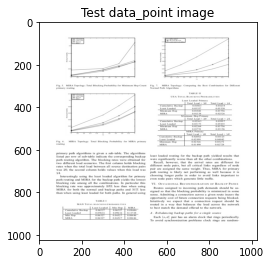

In [ ]:
#display of the random input data point/image
random.seed(1)
data_pt_1 = random.choice(test_paths)
test_img = cv2.imread(data_pt_1)
plt.title('Test data_point image')
plt.imshow(test_img)
plt.show()

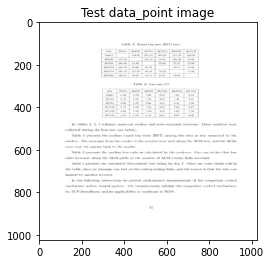

In [ ]:
#display of the random input data point/image
random.seed(9)
data_pt_2 = random.choice(test_paths)
test_img = cv2.imread(data_pt_2)
plt.title('Test data_point image')
plt.imshow(test_img)
plt.show()

<h3>Model architecture: Tablenet model with the pretrained weights</h3>

In [11]:
class Decoder_table(tf.keras.layers.Layer):
    def __init__(self, kernel=1,  filters=[512,256,128,64,3], name="table_mask"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3, self.F4, self.F5 = filters
        self.kernel = kernel
        self.conv7_table = tf.keras.layers.Conv2D(filters=self.F1, kernel_size=self.kernel, activation='relu',name = 'conv7_table')
        self.table_up_b4 = tf.keras.layers.Conv2DTranspose(filters = self.F1, kernel_size = 3, strides = 2, padding='same', name='upsamp_con1')
        self.table_up_b3 = tf.keras.layers.Conv2DTranspose(filters = self.F2, kernel_size = 3, strides = 2, padding='same', name='upsamp_con2')
        self.table_up_op_1 = tf.keras.layers.Conv2DTranspose(filters = self.F3, kernel_size = 3, strides = 2, padding='same', name='upsamp_con3')
        self.table_up_op_2 = tf.keras.layers.Conv2DTranspose(filters = self.F4, kernel_size = 3, strides = 2, padding='same', name='upsamp_con4')
        self.table_up_op_3 = tf.keras.layers.Conv2DTranspose(filters = self.F5, kernel_size = 3, strides = 2, padding='same', name='upsamp_con5')

    def call(self, X):
        inputs, pool3, pool4 = X[0], X[1], X[2]
        conv7table = self.conv7_table(inputs)
        conv7table_upb4 = self.table_up_b4(conv7table)
        pool4_append = tf.keras.layers.concatenate(inputs=[conv7table_upb4, pool4])
        conv7table_upb3 =self.table_up_b3(pool4_append)
        pool3_append = tf.keras.layers.concatenate(inputs=[conv7table_upb3, pool3])
        table_upsamp = self.table_up_op_1(pool3_append)
        table_upsamp = self.table_up_op_2(table_upsamp)
        table_mask_output = self.table_up_op_3(table_upsamp)
    
        return table_mask_output

In [12]:
class Decoder_column(tf.keras.layers.Layer):
    def __init__(self, kernel=1,  filters=[512,256,128,64,3], name="column_mask"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3, self.F4, self.F5 = filters
        self.kernel = kernel
        self.conv7_column = tf.keras.layers.Conv2D(filters=self.F1, kernel_size=self.kernel, activation='relu',name = 'conv7_column')
        self.conv8_column = tf.keras.layers.Conv2D(filters=self.F1, kernel_size=self.kernel, activation='relu',name = 'conv8_column')
        self.table_col_up_b4 = tf.keras.layers.Conv2DTranspose(filters = self.F1, kernel_size = 3, strides = 2, padding='same', name='upsamp_con_col1')
        self.table_col_up_b3 = tf.keras.layers.Conv2DTranspose(filters = self.F2, kernel_size = 3, strides = 2, padding='same', name='upsamp_con_col2')
        self.table_col_up_op_1 = tf.keras.layers.Conv2DTranspose(filters = self.F3, kernel_size = 3, strides = 2, padding='same', name='upsamp_con_col3')
        self.table_col_up_op_2 = tf.keras.layers.Conv2DTranspose(filters = self.F4, kernel_size = 3, strides = 2, padding='same', name='upsamp_con_col4')
        self.table_col_up_op_3 = tf.keras.layers.Conv2DTranspose(filters = self.F5, kernel_size = 3, strides = 2, padding='same', name='upsamp_con_col5')
        self.drop = tf.keras.layers.Dropout(0.2)

    def call(self, X):
        inputs, pool3, pool4 = X[0], X[1], X[2]
        conv7column = self.conv7_column(inputs)
        conv7column =  self.drop(conv7column)
        conv8column = self.conv8_column(conv7column)

        conv8column_upb4 = self.table_col_up_b4(conv8column)
        pool4_append = tf.keras.layers.concatenate(inputs=[conv8column_upb4, pool4])
        conv8column_upb3 =self.table_col_up_b3(pool4_append)
        pool3_append = tf.keras.layers.concatenate(inputs=[conv8column_upb3, pool3])
        table_col_upsamp = self.table_col_up_op_1(pool3_append)
        table_col_upsamp = self.table_col_up_op_2(table_col_upsamp)
        table_col_mask_output = self.table_col_up_op_3(table_col_upsamp)
    
        return table_col_mask_output

In [13]:
X_input = tf.keras.layers.Input(shape=(1024, 1024, 3))
vgg_19 = tf.keras.applications.VGG19(input_tensor=X_input, include_top=False, weights='imagenet',input_shape=(1024,1024,3))
pool3 = vgg_19.get_layer('block3_pool').output
pool4 = vgg_19.get_layer('block4_pool').output
pool5 = vgg_19.get_layer('block5_pool').output

80142336/80134624 [==============================] - 1s 0us/step


In [14]:
#making parameters of pre-trained vgg19 exclusing top layers to non-trainable
for layer in vgg_19.layers:
    layer.trainable = False

In [15]:
conv6 = tf.keras.layers.Conv2D(512, (1, 1), activation = 'relu', name='conv6_1')(pool5)
conv6 = tf.keras.layers.Dropout(0.2, name='conv6_dropout_1')(conv6)

conv6 = tf.keras.layers.Conv2D(512, (1, 1), activation = 'relu', name='conv6_2')(conv6)
conv6 = tf.keras.layers.Dropout(0.2, name='conv6_dropout_2')(conv6)

In [16]:
table_mask = Decoder_table(kernel=1,filters=[512,256,128,64,3])([conv6,pool3,pool4])
table_column_mask = Decoder_column(kernel=1,filters=[512,256,128,64,3])([conv6,pool3,pool4])

In [17]:
model = tf.keras.Model(inputs=X_input,outputs=[table_mask, table_column_mask],name="Tablenet")

In [18]:
BATCH_S = 4
losses = {
    "table_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "column_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=losses,metrics=['accuracy'])

In [19]:
#loading weights of tablenet model pretrained
model.load_weights("tablenet_vgg19_e50.h5")

In [20]:
#this method performs the pre-processing steps before predicting the table mask for the image passed as input to the model
def test_preprocess(path_name):
    image_string = tf.io.read_file(path_name)
    image = tf.io.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image  = tf.image.resize(image, [1024, 1024])
    return image

In [21]:
#this method returns information extracted from the image of the document containing table
def text_extraction(image,pred_table_mask,pred_column_mask):
    #original image
    doc_img = tf.keras.preprocessing.image.array_to_img(image[0])
    doc_img = cv2.cvtColor(np.asarray(doc_img), cv2.COLOR_RGB2BGR)
    doc_img = cv2.resize(doc_img, (1024,1024))
    doc_img = Image.fromarray(doc_img)
    #model predicted table mask
    tab_msk = tf.keras.preprocessing.image.array_to_img(pred_table_mask)
    
    tab_msk = tab_msk.convert('L')
    #adding grayscale table_mask image to the original image to the table portion from the image
    doc_img.putalpha(tab_msk)
    #ref: https://www.analyticsvidhya.com/blog/2020/05/build-your-own-ocr-google-tesseract-opencv/
    config = ('-l eng --oem 1 --psm 3')
    #text extraction using pytesseract
    text = pytesseract.image_to_string(doc_img, config=config)
    return text

In [22]:
#this method returns csv file of the information extracted from the image of the document containing table
def text_extraction_to_csv(extracted_text,csv_name):
    with open(csv_name, 'w', newline='') as file:
        writer=csv.writer(file)
        extracted_text = extracted_text.lstrip()
        filtered_text = []
        for ele in (extracted_text.split('\n')):
            if ele != '':
                filtered_text.append(ele.split(' '))
        for f_ele in filtered_text:
            data=','.join(f_ele)
            writer.writerow(data.split(','))

In [ ]:
#this method returns csv file of the information extracted from the image of the document containing table
def text_extraction_to_txt(extracted_text,txt_name):
    f = open(txt_name,"w+")
    extracted_text = extracted_text.lstrip()
    filtered_text = []
    for ele in (extracted_text.split('\n')):
        if ele != '':
            filtered_text.append(ele.split(' '))
    for f_ele in filtered_text:
        data=','.join(f_ele)
        print(data)
        f.write(' '.join(data.split(','))+'\n')
    f.close() 

In [25]:
#final_func_1 takes input image and predicts and displays the table-mask, column-mask and table in the image
def final_func_1(X):
    txt_name = X.split('/')[-1].replace('_resized.jpeg','.txt')
    files_list = tf.data.Dataset.list_files(X)
    test_size = len(list(files_list))
    test = files_list.take(test_size)
    BS = 1
    test = test.map(test_preprocess)
    test_data = test.batch(BS)
    for image in test_data.take(1):
        pred_tab, pred_col = model.predict(image)
        pred_tab = tf.argmax(pred_tab, axis=-1)
        pred_tab = pred_tab[..., tf.newaxis]
        pred_col = tf.argmax(pred_col, axis=-1)
        pred_col = pred_col[..., tf.newaxis]
        table_mask, column_mask = pred_tab[0], pred_col[0]

        #input image
        raw_inp_img = tf.keras.preprocessing.image.array_to_img(image[0])
        inp_img = cv2.cvtColor(np.asarray(raw_inp_img), cv2.COLOR_RGB2BGR)
        inp_img = cv2.resize(inp_img, (1024,1024))
        table_from_img = Image.fromarray(inp_img)
        #model predicted table mask
        pred_tab_msk = tf.keras.preprocessing.image.array_to_img(table_mask)
        pred_col_msk = tf.keras.preprocessing.image.array_to_img(column_mask)
        tab_msk = pred_tab_msk.convert('L')
        #adding grayscale table_mask image to the original image to the table portion from the image
        table_from_img.putalpha(tab_msk)

        plt.figure(figsize=(15, 15))
        title = ['Input Image', 'Table Mask', 'Column Mask', 'Extracted Table from image']
        plot_img = [raw_inp_img, pred_tab_msk, pred_col_msk, table_from_img]
        for i in range(len(plot_img)):
            plt.subplot(1, 4, i+1)
            plt.title(title[i])
            plt.imshow(plot_img[i])    
        plt.show()
        extracted_text = text_extraction(image,table_mask, column_mask)
        print('Text extracted from the table using pytesseract \n',extracted_text)
        text_extraction_to_csv(extracted_text,txt_name)

Display of the test input image along with it's predicted table and column masks and table in the image


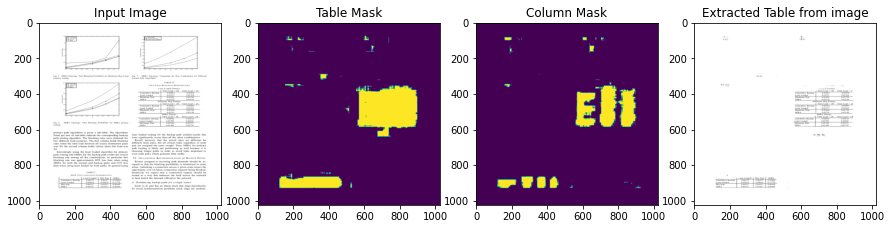

Text extracted from the table using pytesseract 
 je

 

  

 

 

 

 

 

 

iny for .
< teatied Primary
Total Load = JU" Total Load = 2
CORTE
0.05330
8.03 756
0.01334 0.02526
Tataram Hop Primary
‘Total Load = 20 Total Load = 24
Least Loaded 0.03173 0.05035
Minimum Hop oorze 8.03 756
MIRA 0.01791 03196
MIRA Primary
‘Total Loal = JU Total Load = 24
Tamulsive Backap | 0.0208 ©:
Least Loaded 0.02999 o.oasa2
“Minimum Hop 0.02525 ——o.03717
MIRA 0.01490 0.02728
or the ba:
4
east Loaded | Min H. MIRA
Tamataive Backup | 0.06527 | 0.08: woRate
Least Loaded oos6i6 | 0.09616 | 0.11728 .
Nin Top Tae5IT | 06527 | ORG
DALRA 0.06527 _|_0.06527 | o.ossae

 

 

 

 



In [ ]:
print("Display of the test input image along with it's predicted table and column masks and table in the image")
final_func_1(data_pt_1)

Display of the test input image along with it's predicted table and column masks and table in the image


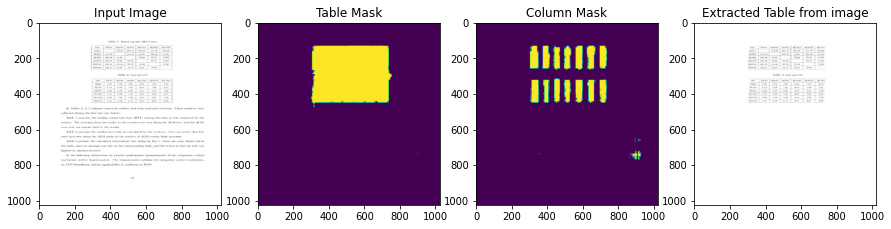

Text extracted from the table using pytesseract 
  

   

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

site RONG | RON? | RONS3 | RONSS | RONG
inact v0.07 | 2ea15 | 20525 | avveo | 213.99
KONO | Wee qui | one, | ww | exe
RON? | 266.60 | SL9F 37.65 | 77.15 | 87.87
noNsa | z3e.20 | co.0e | 88.70 e526 | 2668
wonse | was | as | seen | vezs sua
KON@ | saza7 | eas | on7e | zozr | once
Vable 2: Lees rate (%)
Sie | zmatt | RONG | RON? | RON? | RONSS

‘eni | eco | cco | so | one | 10s

KONG | oss | wey | saz | uae | 7au | 2av

RON: | 430 | ze7 | coe ese 6
woxaa | ean | eco | aan zea | 207
KONae | tao | eee | on | ves | ane | ow

 

 

 

 

 

 

 



In [ ]:
print("Display of the test input image along with it's predicted table and column masks and table in the image")
final_func_1(data_pt_2)

In [ ]:
#final_func_2 takes input image and it's ground truth table and column masks and evaluates the F1-score for table and column masks with predicted table and column masks from the model
def final_func_2(X,y):

    files_list = tf.data.Dataset.list_files(X)
    test_size = len(list(files_list))
    test = files_list.take(test_size)
    BS = 1
    test = test.map(test_preprocess)
    test_data = test.batch(BS)

    ground_table_mask = []
    ground_table_col_mask = []
    pred_table_mask = []
    pred_tab_col_mask = []

    #reading path 
    table_string = tf.io.read_file(y['table_mask'])
    #decoding image
    table_mask = tf.io.decode_jpeg(table_string, channels=1)

    # This will convert to float values in [0, 1]
    table_mask = tf.image.convert_image_dtype(table_mask, tf.float32)
    #resize the image
    table_mask = tf.image.resize(table_mask, [1024, 1024])
    ground_table_mask.append(table_mask)
    
    #reading path 
    column_string = tf.io.read_file(y['column_mask'])
    #decoding image
    column_mask = tf.io.decode_jpeg(column_string, channels=1)

    # This will convert to float values in [0, 1]
    column_mask = tf.image.convert_image_dtype(column_mask, tf.float32)
    #resize the image
    column_mask = tf.image.resize(column_mask, [1024, 1024])
    ground_table_col_mask.append(column_mask)

    for image in test_data.take(1):
        pred_tab, pred_col = model.predict(image)
        pred_tab = tf.argmax(pred_tab, axis=-1)
        pred_tab = pred_tab[..., tf.newaxis]
        pred_col = tf.argmax(pred_col, axis=-1)
        pred_col = pred_col[..., tf.newaxis]
        predtable_mask, predcolumn_mask = pred_tab[0], pred_col[0]
        pred_table_mask.append(predtable_mask)
        pred_tab_col_mask.append(predcolumn_mask)

    tab_pre = tf.keras.metrics.Precision()
    tab_pre.update_state(ground_table_mask, pred_table_mask)
    table_precision = tab_pre.result().numpy()
    tab_rec = tf.keras.metrics.Recall()
    tab_rec.update_state(ground_table_mask, pred_table_mask)
    table_recall = tab_rec.result().numpy()
    table_F1_score = (2 * (table_recall * table_precision))/(table_recall+table_precision)

    tabcol_pre = tf.keras.metrics.Precision()
    tabcol_pre.update_state(ground_table_col_mask, pred_tab_col_mask)
    table_col_precision = tabcol_pre.result().numpy()
    tabcol_rec = tf.keras.metrics.Recall()
    tabcol_rec.update_state(ground_table_col_mask, pred_tab_col_mask)
    table_col_recall = tabcol_rec.result().numpy()
    col_F1_score = (2 * (table_col_recall * table_col_precision))/(table_col_recall+table_col_precision)

    return table_F1_score,col_F1_score

In [ ]:
random.seed(9)
data_pt = random.choice(test_paths)
y = {'table_mask':data_pt.replace('resize_image','table_mask').replace('_resized','_table_mask'),'column_mask':data_pt.replace('resize_image','column_mask').replace('_resized','_col_mask')}

In [ ]:
print('The evaluated performance metric F1-score for the table-mask and column-mask predicted respectively  is: ',[round(score,3) for score in final_func_2(data_pt,y)])

The evaluated performance metric F1-score for the table-mask and column-mask predicted respectively  is:  [0.965, 0.782]
